In [212]:
import os

In [213]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\Loan-Amount-Prediction'

In [214]:
os.chdir("../")

In [215]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [216]:
project_path = "C:/Users/RICH-FILES/Desktop/ml/Loan-Amount-Prediction"

os.chdir(project_path)

In [217]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    all_params: dict
    metric_file_name:Path
    target_column: int
    mlflow_uri:str


In [218]:
from credit_risk.constants import *
from credit_risk.utils.common import read_yaml, create_directories, save_json

In [219]:
#creating a Configuration class
class ConfigurationManager:
    def __init__(
        self,
        config_filepath   = CONFIG_FILE_PATH,
        params_filepath   = PARAMS_FILE_PATH,
        schema_filepath   = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)                       
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
    
    def get_model_evaluation_config(self)-> ModelEvaluationConfig:
        config= self.config.model_evaluation
        params= self.params.RandomForestRegressor
        schema= self.schema.TARGET_COLUMN
        
        create_directories([config.root_dir])
        
        model_evaluation_config=ModelEvaluationConfig(
            root_dir= config.root_dir,
            test_data_path=config.test_data_path,
            model_path=config.model_path,
            all_params=params,
            metric_file_name=config.metric_file_name,
            target_column=schema.name,
            mlflow_uri="https://dagshub.com/richardmukechiwa/Loan-Amount-Prediction"
            
        )
        
        return model_evaluation_config
        

In [220]:
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import numpy as np
import joblib
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np


In [221]:
class ModelEvaluation:
    def __init__(self, config:ModelEvaluationConfig):
        self.config=config
        
    def eval_metrics(self, actual, pred):
        rmse=np.sqrt(mean_squared_error(actual, pred))
        mae=mean_absolute_error(actual, pred)
        r2= r2_score(actual, pred)
        
        return rmse, mae, r2
        
    
    def log_into_mlflow(self):
        
        test_data = pd.read_csv(self.config.test_data_path)
        model=joblib.load(self.config.model_path)
        
        
        test_data.dropna(inplace=True)
        
        print(test_data.head())
       
        test_x=test_data.drop([self.config.target_column], axis=1)
        test_y= test_data[[self.config.target_column]]
        
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        with mlflow.start_run():
            
            predicted_qualities=model.predict(test_x)
            
            (rmse, mae, r2) = self.eval_metrics(test_y, predicted_qualities)
            
            # saving metrics as local
            scores= {"rmse":rmse, "mae": mae, "r2":r2}
            save_json(path=Path(self.config.metric_file_name), data=scores)
            
            mlflow.log_params(self.config.all_params)
            
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)
            
            #Model registry does not work with file store
            #if tracking_url_type_store != "file":
                
                # Register the model
                
                # There are other ways to use the Model Registry, which depends on the use case
                
                # please refer to the docs: https://mlflow.org/docs/latest/models-reqistry.html # api-workflow
                # mlflow.sklearn.log_model(model, "model")
            #else:
                #mlflow.sklearn.log_model(model, "model") 
                   
    def hist(self):
        test_data = pd.read_csv(self.config.test_data_path)
        model=joblib.load(self.config.model_path)


        test_data.dropna(inplace=True)

        print(test_data.head())

        test_x=test_data.drop([self.config.target_column], axis=1)
        test_y= test_data[[self.config.target_column]]

        predicted_qualities=model.predict(test_x)

        # Create a figure with two subplots: residual scatter plot and histogram
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        residuals = test_y.values.flatten() - predicted_qualities
        

        # Residuals vs. Fitted Values (Scatter Plot)
        sns.scatterplot(x=predicted_qualities, y=residuals, ax=axes[0], alpha=0.7)
        axes[0].axhline(y=0, color='red', linestyle='--')
        axes[0].set_xlabel("Predicted Values")
        axes[0].set_ylabel("Residuals")
        axes[0].set_title("Residuals vs. Fitted Values")
        axes[0].grid(True)

        # Histogram of Residuals
        sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
        axes[1].set_xlabel("Residuals")
        axes[1].set_ylabel("Frequency")
        axes[1].set_title("Histogram of Residuals")
        axes[1].grid(True)

        # Show the plots
        plt.tight_layout()
        return plt.show()          
             
            
        
        
        

[2025-03-23 00:28:40,647: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-23 00:28:40,650: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-23 00:28:40,655: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-23 00:28:40,656: INFO: common: created directory at: artifacts]
[2025-03-23 00:28:40,658: INFO: common: created directory at: artifacts/model_evaluation]
   Age  Income      Home  Emp_length             Intent  Amount   Rate  \
0   25   22800      RENT         0.0            MEDICAL    6000  13.35   
1   24   43200      RENT         8.0            MEDICAL    7200  13.49   
2   22   85000  MORTGAGE         4.0            VENTURE    7000   6.91   
3   26   45000  MORTGAGE         0.0  DEBTCONSOLIDATION    7750  12.53   
4   24   33000      RENT         8.0            MEDICAL    6400   9.99   

   Percent_income  Cred_length  
0            0.26            4  
1            0.17            4  
2            0.08            3  
3

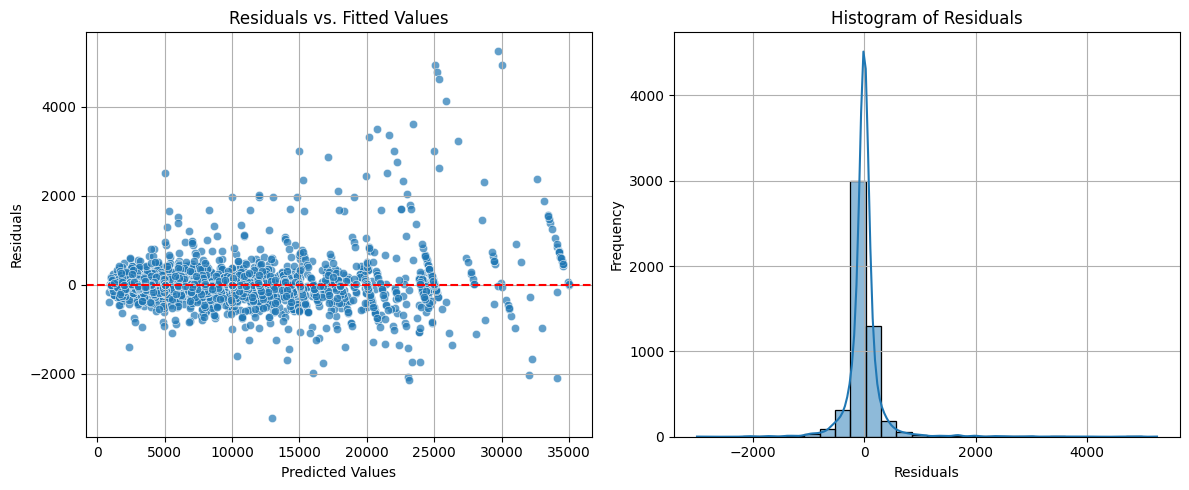

In [222]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)

    # Call the hist() method with the correct arguments
    model_evaluation.hist()

except Exception as e:
    raise e


In [223]:
#define pipeline
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config=ModelEvaluation(config=model_evaluation_config)
    model_evaluation_config.log_into_mlflow()
except Exception as e:
    raise e    

[2025-03-23 00:28:41,533: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-23 00:28:41,537: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-23 00:28:41,540: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-23 00:28:41,542: INFO: common: created directory at: artifacts]
[2025-03-23 00:28:41,543: INFO: common: created directory at: artifacts/model_evaluation]
   Age  Income      Home  Emp_length             Intent  Amount   Rate  \
0   25   22800      RENT         0.0            MEDICAL    6000  13.35   
1   24   43200      RENT         8.0            MEDICAL    7200  13.49   
2   22   85000  MORTGAGE         4.0            VENTURE    7000   6.91   
3   26   45000  MORTGAGE         0.0  DEBTCONSOLIDATION    7750  12.53   
4   24   33000      RENT         8.0            MEDICAL    6400   9.99   

   Percent_income  Cred_length  
0            0.26            4  
1            0.17            4  
2            0.08            3  
3